## Content of tables

<a id="toc_01_src" href="#toc_01_dest">Basic model</a>

<a id="toc_02_src" href="#toc_02_dest">Attention model</a>

<a id="toc_03_src" href="#toc_03_dest">Attention visualization</a>

<a id="toc_04_src" href="#toc_04_dest">Exploration report</a>

Bottom:

<a id="toc_05_src" href="#toc_05_dest">Static graphs</a>

<a id="toc_06_src" href="#toc_06_dest">External code</a>


## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [209]:
!wget --no-verbose -O train.py https://raw.githubusercontent.com/virtualphoton/ds_utils/9b3d7dd3530bc1a045100beb767cf612a20942a7/train.py
!wget --no-verbose -O checkpoint.py https://raw.githubusercontent.com/virtualphoton/ds_utils/fc0a72f1ef0d80523756e3a6783f35fe9d3270b5/checkpoint.py
!wget --no-verbose -O plotter.py https://raw.githubusercontent.com/virtualphoton/ds_utils/fc0a72f1ef0d80523756e3a6783f35fe9d3270b5/plotter.py
!wget --no-verbose -O magic.py https://raw.githubusercontent.com/virtualphoton/ds_utils/9d95eb665854cf529eeac9f2ce6d41dd8289d56a/magic.py
!wget --no-verbose -O torch_utils.py https://raw.githubusercontent.com/virtualphoton/ds_utils/06aa942d26dc6a81eef656c555fa4894ebfc773c/torch_utils.py

2023-10-21 23:22:39 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/9b3d7dd3530bc1a045100beb767cf612a20942a7/train.py [4096/4096] -> "train.py" [1]
2023-10-21 23:22:39 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/fc0a72f1ef0d80523756e3a6783f35fe9d3270b5/checkpoint.py [3645/3645] -> "checkpoint.py" [1]
2023-10-21 23:22:40 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/fc0a72f1ef0d80523756e3a6783f35fe9d3270b5/plotter.py [6875/6875] -> "plotter.py" [1]
2023-10-21 23:22:41 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/9d95eb665854cf529eeac9f2ce6d41dd8289d56a/magic.py [5704/5704] -> "magic.py" [1]
2023-10-21 23:22:42 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/06aa942d26dc6a81eef656c555fa4894ebfc773c/torch_utils.py [1747/1747] -> "torch_utils.py" [1]


In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
from ds_utils.train import loopa, mean_metric
from ds_utils.checkpoint import EarlyStopper, State
from ds_utils.magic import reprint, get_outputs
from ds_utils.plotter import Plotter, History, plotly_static
from ds_utils.torch_utils import device_default

In [212]:
from IPython.display import clear_output, display

In [213]:
IMLADRIS = False

In [214]:
import torch
from torchvision import transforms
from tqdm.auto import tqdm

imladris_quadro = list(range(2, 7))
physical_to_torch = {1:0, 2:1, 0 : 2, 6 : 6, 5 : 5}

def get_computing_device(dev = 0):
    if torch.cuda.is_available():
        if globals().get("IMLADRIS", False):
            device = torch.device(f'cuda:{physical_to_torch[dev]}')
        else:
            device = torch.device("cuda")
        
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device(6)
print(device)

cuda


In [215]:
# !pip3 install subword-nmt &> log
# !wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
# !wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [216]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|█████████████████████████████████████| 8000/8000 [00:04<00:00, 1677.85it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [217]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [219]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [220]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

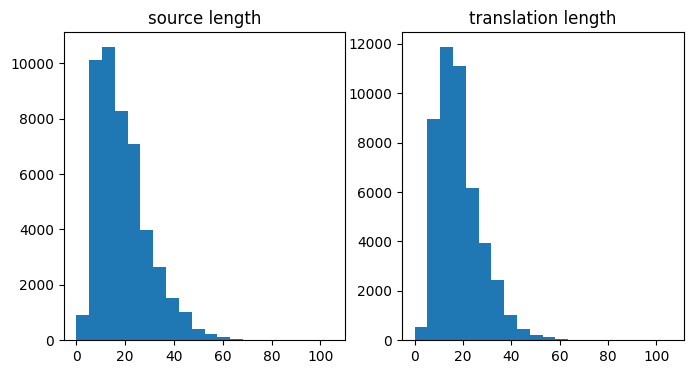

In [221]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

<a id="toc_01_dest" href="#toc_01_src">[TOC]</a>

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc: Vocab, out_voc: Vocab, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [15]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [16]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
washer ruck ı šiben@@ sc@@ ą@@ ą@@ puerta boo@@ sozopol flooring operating riv@@ cala requests huang timber und ament marac@@ a@@ howard tro fu@@ prior
pur smart riv@@ granada bed bed desks salzburg parlo@@ sta express classic naz@@ rambla ages visiting pper cher lov@@ playground aber@@ ros attan power rides
pur smart riv@@ granada bed bed desks salzburg parlo@@ sta express classic naz@@ rambla ages visiting pper cher lov@@ playground aber@@ ros attan power rides


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [17]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = - logits_seq.log_softmax(dim=-1)
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return logp_out[mask].mean() # average loss, scalar

In [18]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5481, device='cuda:0', grad_fn=<MeanBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [19]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [20]:
compute_bleu(model, dev_inp, dev_out)

0.002182009235075692

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [197]:
model = BasicModel(inp_voc, out_voc).to(device)

batch_size = 32
basic_state = State(model,
                    torch.optim.Adam(model.parameters(), lr=1e-3),
                    History(),
                    "./storage/basic.pth")

metrics = {'train_loss': [], 'dev_bleu': [] }

/home/photon/PyProjects/nlp_course/week04_seq2seq/ds_utils/checkpoint.py:27: UserWarning:

Saver: ./storage/basic.pth already exists!



In [ ]:
%%reprint
torch.cuda.empty_cache()
model, opt, history, _ = basic_state.as_tuple()
plotter = Plotter(bound_history=history)
stopper = EarlyStopper(basic_state, patience=15,
                       loss="-dev_bleu")

plot_every = 100
for _ in history.range(25_000, stopper, do_tqdm=True):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    loss_t = compute_loss(model, batch_inp, batch_out)
    opt.zero_grad()
    loss_t.backward()
    opt.step()
    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % plot_every == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        epoch = ({"loss": metrics['train_loss'][-1][1]}, {"dev_bleu": metrics['dev_bleu'][-1][1]})
        history.push_epoch(*epoch)
        plotter.plot()
        
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [198]:
basic_plotter = Plotter(bound_history=basic_state.load_history())
basic_plotter.plot()
clear_output()
plotter.draw_no_widget()

<a id="1_src" href="#1_dest">to static img</a>

In [44]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [45]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking and bike hire .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the bathroom is 26 km from the hotel .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
set in a peaceful area , a 5 - minute walk from the beach , the cycladic - style house features a garden and a garden .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in the centre of saint - emil@@ ia , the apartment is a 5 - minute walk from the property .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and free toiletries .



### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

<a id="toc_02_dest" href="#toc_02_src">[TOC]</a>

In [30]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        self.linear_e = nn.Linear(self.enc_size, self.hid_size)
        self.linear_d = nn.Linear(self.dec_size, self.hid_size)
        self.linear_out = nn.Linear(self.hid_size, 1)
        

    def forward(self, enc, dec, inp_mask, interm_enc = None):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
            - intermideate encoding value
        """

        # Compute logits
        if interm_enc is None:
            interm_enc = self.linear_e(enc)
        logits = self.linear_out(self.activ(interm_enc +
                                            self.linear_d(dec)[:, None, :]))
        logits.squeeze_(dim=-1)
        

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        

        # Compute attention probabilities (softmax)
        probs = logits.where(inp_mask, -torch.inf).softmax(dim=-1)

        # Compute attention response using enc and probs
        attn = (enc * probs[..., None]).sum(dim=1)
        return attn, probs, interm_enc

### Seq2seq model with attention (3 points)


In [40]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128,
                 att_layer_class=AttentionLayer):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        
        self.attention = att_layer_class("attention", hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)
        mask = self.inp_voc.compute_mask(inp_emb)[..., 0]
        
        lengths = mask.sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        
        # apply attention layer from initial decoder hidden state
        attn, first_attn_probas, interm = self.attention(enc_seq, dec_start, mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, (enc_seq, attn, mask, interm), first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        prev_gru0_state, (enc_seq, attn, mask, interm), _ = prev_state
        emb = self.emb_out(prev_tokens)
        
        dec_inp = torch.cat([emb, attn], dim=-1)
        new_gru0_state = self.dec0(dec_inp, prev_gru0_state)
        output_logits = self.logits(new_gru0_state)
        
        new_attn, new_probas, new_interm = self.attention(enc_seq, new_gru0_state, mask, interm)
        new_dec_state = [new_gru0_state, (enc_seq, new_attn, mask, new_interm), new_probas]
        
        return [new_dec_state, output_logits]


### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [23]:
from torch.utils.data import DataLoader
from functools import partial
batch_size = 64
num_workers = 12

train_data = list(zip(train_inp, train_out))
val_data = list(zip(dev_inp, dev_out))

def collate_fn(batch, vocs):
    inp_voc, outp_voc = vocs
    inps, outps = zip(*batch)
    inps = inp_voc.to_matrix(inps)
    outps = outp_voc.to_matrix(outps)
    return inps, outps

train_loader = DataLoader(train_data, shuffle=True,
                          collate_fn=partial(collate_fn, vocs=[inp_voc, out_voc]),
                          batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_data, shuffle=False,
                        collate_fn=partial(collate_fn, vocs=[inp_voc, out_voc]),
                        batch_size=batch_size, num_workers=num_workers)

In [254]:
model = AttentiveModel("none", inp_voc, out_voc).to(device)

att_state = State(model,
                  torch.optim.Adam(model.parameters(), lr=1e-3),
                  History(),
                  "./storage/att2.pth")

/home/photon/PyProjects/nlp_course/week04_seq2seq/ds_utils/checkpoint.py:27: UserWarning:

Saver: ./storage/att2.pth already exists!



In [136]:
import warnings

@reprint
def att_loop(state, num_epochs, patience=3):
    model, opt, history, scheduler = state.as_tuple()
    torch.cuda.empty_cache()
    plotter = Plotter(bound_history=history)
    stopper = EarlyStopper(state, patience=patience, loss="-dev_bleu")

    for i in history.range(num_epochs, stopper, do_tqdm=True):
        model.train()
        loss = 0
        for j, (batch_inp, batch_out) in enumerate(tqdm(train_loader)):
            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp.to(device), batch_out.to(device))
            loss += loss_t.item()
            loss_t.backward()
            opt.step()
            if scheduler is not None:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    scheduler.step(i + j / len(train_loader))
        loss /= len(train_data)

        model.eval()
        bleu = compute_bleu(model, dev_inp, dev_out)
        history.push_epoch({"loss" : loss}, {"dev_bleu" : bleu})
        plotter.plot()

In [ ]:
%%reprint
att_loop(att_state, 20)

In [255]:
att_plotter = Plotter(bound_history=att_state.load_history())
att_plotter.plot()
clear_output()
att_plotter.draw_no_widget()

Lost original plot because I've overwritten it in one of the buggy functions (though plotly graph remained intact)

<a id="2_src" href="#2_dest">to static img</a>

In [25]:
att_state.load_inplace()
model = att_state.model

In [27]:
print(compute_bleu(model, dev_inp, dev_out))

23.451808727637832


### Visualizing model attention (2 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [37]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))
    show(fig)

Loading BokehJS ...

In [35]:
inp = dev_inp[::100]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = np.stack([state[-1].detach().cpu().numpy() for state in states], axis=1)

In [ ]:
for i in range(5, 15):
    draw_attention(inp[i], trans[i], attention_probs[i])
# Does it look fine already? don't forget to save images for anytask!

<a id="toc_03_dest" href="#toc_03_src">[TOC]</a>

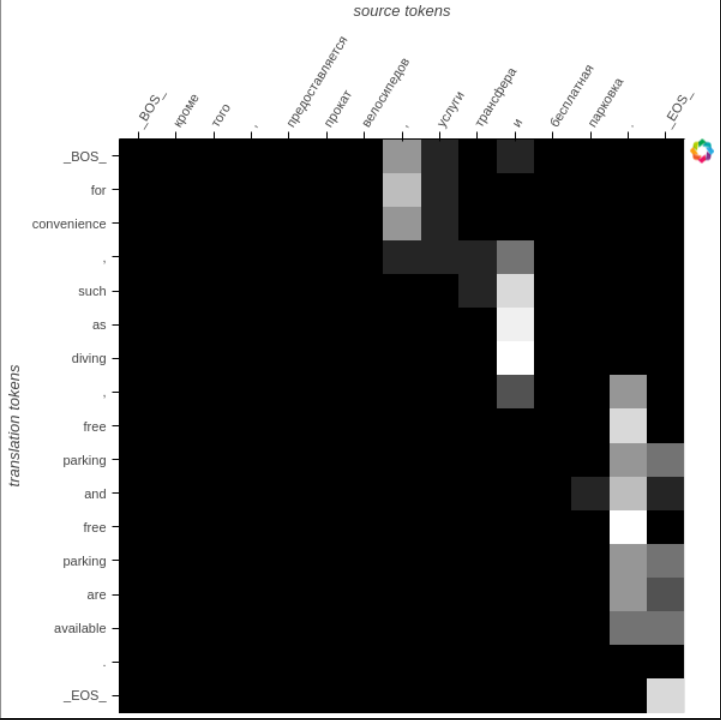

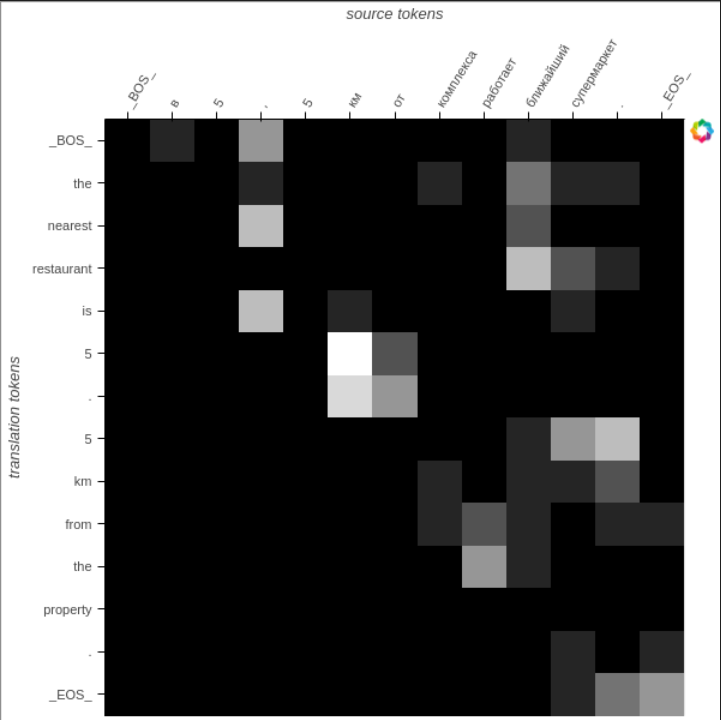

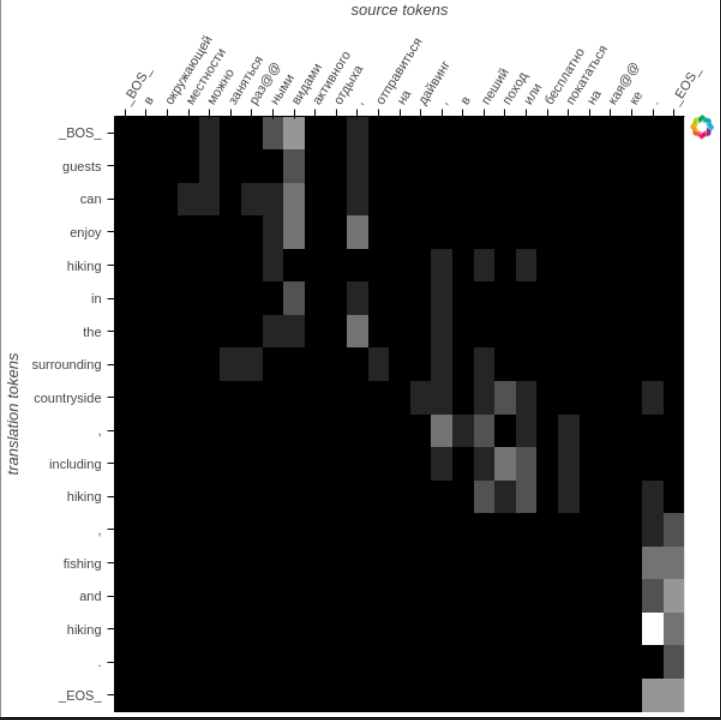

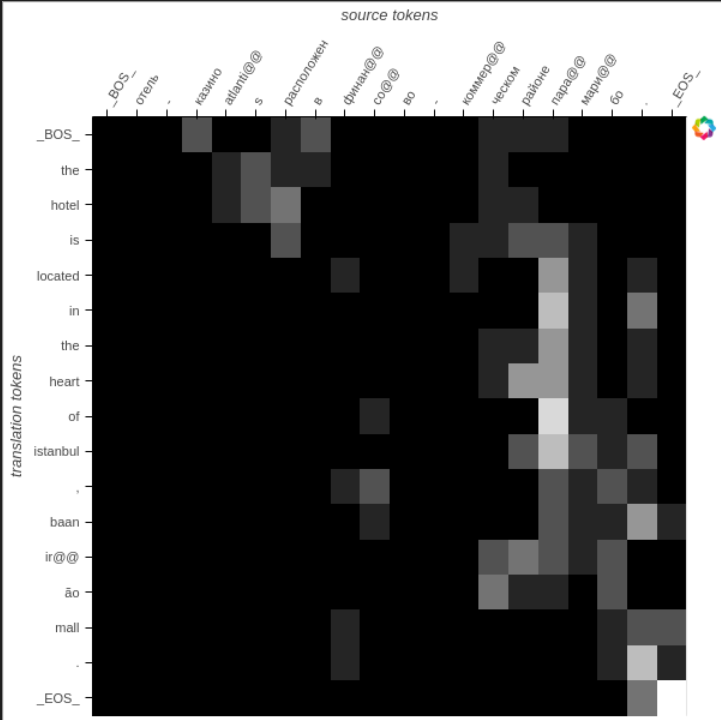

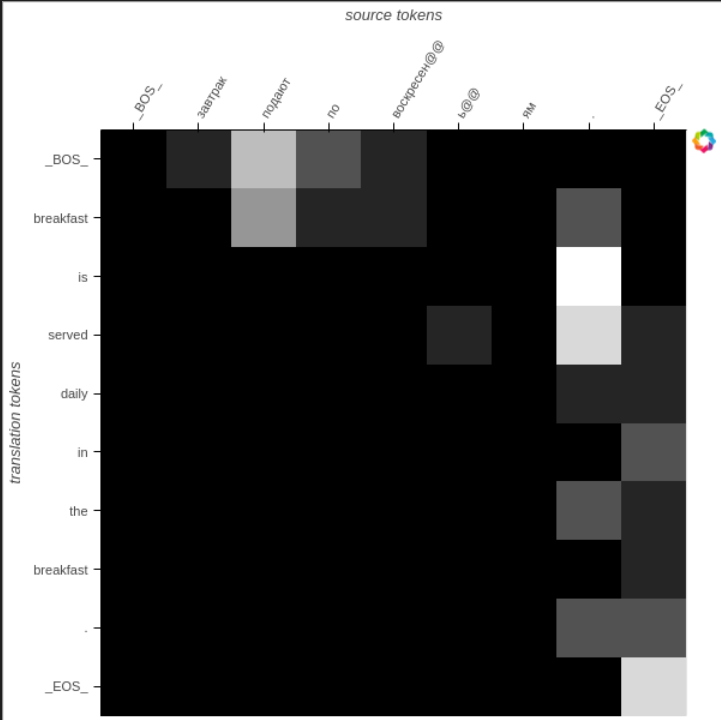

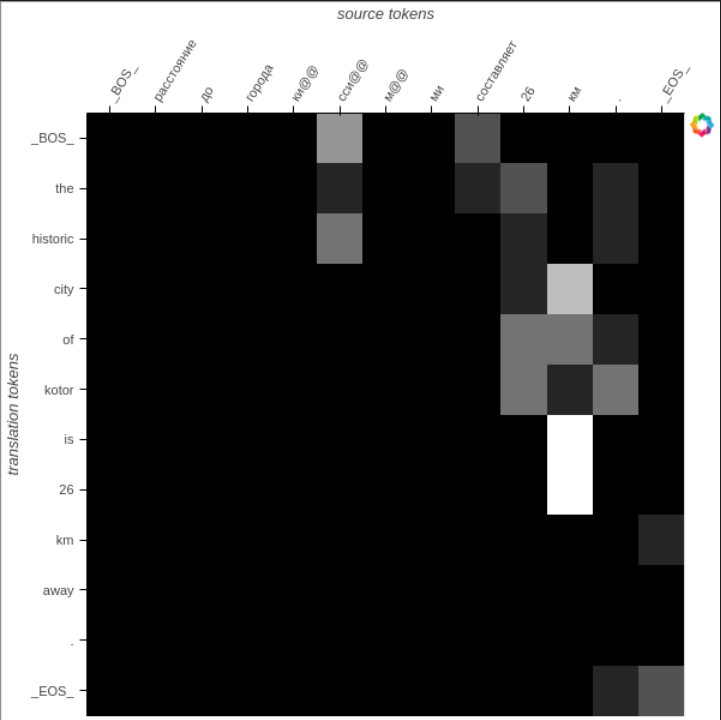

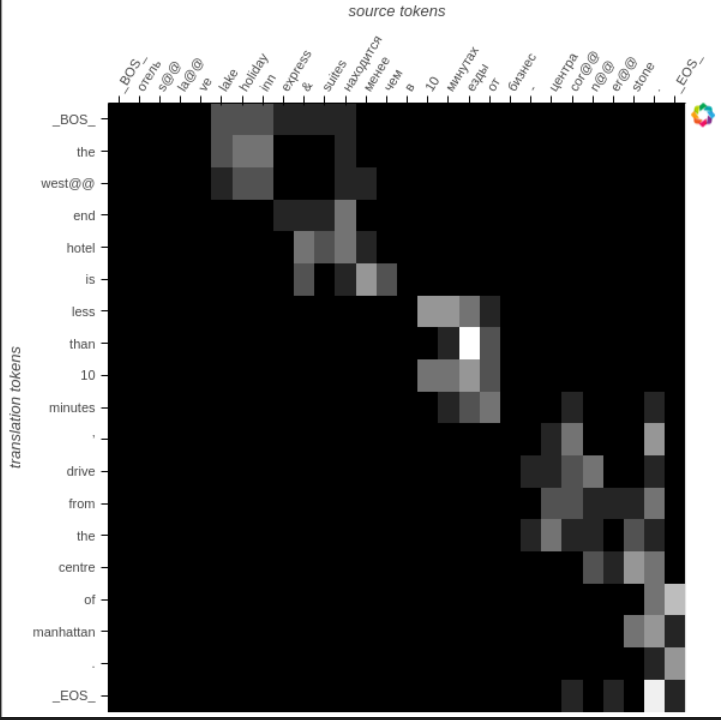

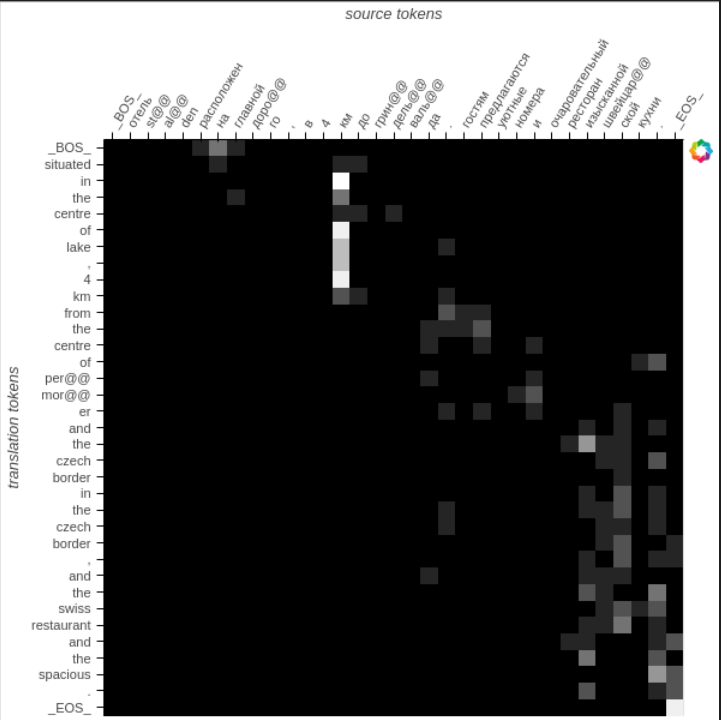

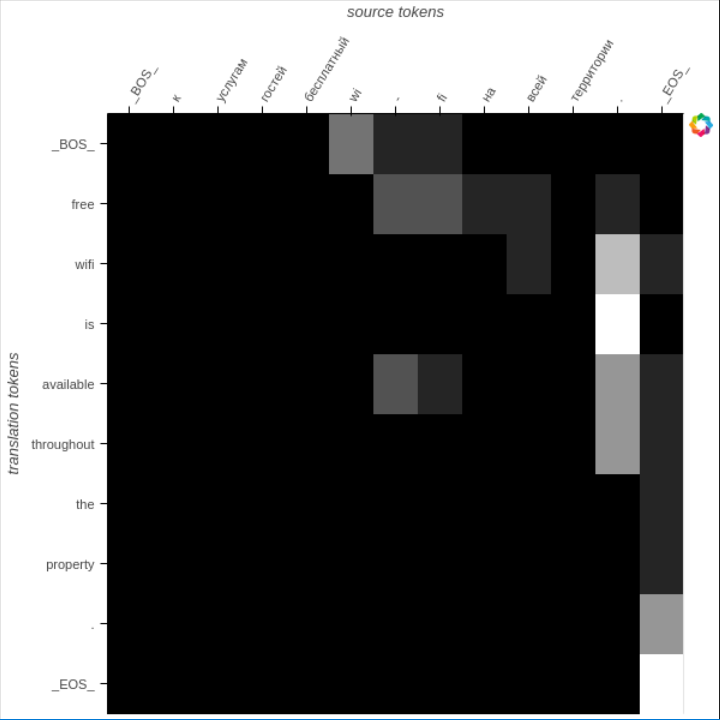

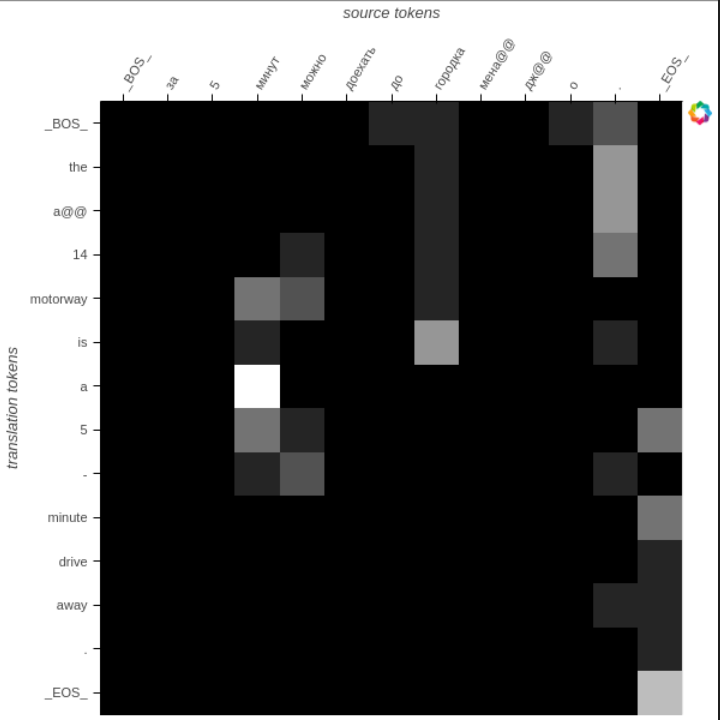

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

In [43]:
class DotProductAttention(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        
        self.linear_e = nn.Linear(self.enc_size, self.hid_size)
        self.linear_d = nn.Linear(self.dec_size, self.hid_size)
        self.lin_value = nn.Linear(self.enc_size, self.enc_size)

    def forward(self, enc, dec, inp_mask, interm_enc = None):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
            - intermideate encoding value
        """

        # Compute logits
        if interm_enc is None:
            interm_enc = self.linear_e(enc)
        logits = (interm_enc * self.linear_d(dec)[:, None, :]).sum(-1)
        # Compute attention probabilities (softmax)
        logits /= self.hid_size ** .5
        probs = logits.where(inp_mask, -torch.inf).softmax(dim=-1)

        # Compute attention response using enc and probs
        attn = (self.lin_value(enc) * probs[..., None]).sum(dim=1)
        
        return attn, probs, interm_enc

In [234]:
model = AttentiveModel("none", inp_voc, out_voc, att_layer_class=DotProductAttention).to(device)

dot_state = State(model,
                  torch.optim.Adam(model.parameters(), lr=1e-3),
                  History(),
                  "./storage/att_dot.pth")

/home/photon/PyProjects/nlp_course/week04_seq2seq/ds_utils/checkpoint.py:27: UserWarning:

Saver: ./storage/att_dot.pth already exists!



In [ ]:
%%reprint
att_loop(dot_state, 40, 5)

In [248]:
dot_plotter = Plotter(bound_history=dot_state.load_history())
dot_plotter.plot()
clear_output()
dot_plotter.draw_no_widget()

<a id="3_src" href="#3_dest">to static img</a>

In [105]:
import torch.optim as optim

class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    # https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [239]:
model = AttentiveModel("none", inp_voc, out_voc, att_layer_class=DotProductAttention).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 40
warmup = 5

dot_warmup_state = State(model, opt, History(),
                         scheduler=CosineWarmupScheduler(opt, warmup, num_epochs),
                         path="./storage/att_dot_warmup.pth")

/home/photon/PyProjects/nlp_course/week04_seq2seq/ds_utils/checkpoint.py:27: UserWarning:

Saver: ./storage/att_dot_warmup.pth already exists!



In [ ]:
%%reprint
att_loop(dot_warmup_state, 40, 5)

In [249]:
dot_warmup_plotter = Plotter(bound_history=dot_warmup_state.load_history())
dot_warmup_plotter.plot()
clear_output()
dot_warmup_plotter.draw_no_widget()

<a id="4_src" href="#4_dest">to static img</a> 

In [174]:
class MultiheadAttention(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, num_heads, att_dropout=0):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        assert not hid_size % num_heads
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.num_heads = num_heads
        self.head_size = hid_size // num_heads
        
        self.norm_coeff = self.head_size ** 0.5
        
        self.linear_e = nn.Linear(self.enc_size, self.hid_size)
        self.linear_d = nn.Linear(self.dec_size, self.hid_size)
        self.lin_value = nn.Linear(self.enc_size, self.hid_size)
        self.out_proj = nn.Linear(self.hid_size, self.enc_size)
        self.dropout = nn.Dropout(att_dropout)

    def forward(self, enc, dec, inp_mask, interm = None):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
            - intermideate encoding value
        """
        # Compute logits
        if interm is None:
            inter_k = self.linear_e(enc).reshape(*enc.shape[:2], self.num_heads, -1).movedim(-2, 0)
            inter_v = self.lin_value(enc).reshape(*enc.shape[:2], self.num_heads, -1).movedim(-2, 0)
            
            interm = (inter_k, inter_v)
        
            
        Q = self.linear_d(dec)[:, None, :]
        Q = Q.reshape(*Q.shape[:2], self.num_heads, -1).movedim(-2, 0)
        K, V = interm
        
        logits = (Q @ K.movedim(-1, -2)) / self.norm_coeff
        probs = logits.where(inp_mask[:, None, :], -torch.inf).softmax(dim=-1)
        att_results = probs @ V
        
        att_results = self.dropout(att_results)
        att_results = att_results.squeeze(-2).movedim(0, 1).flatten(-2)
        
        return self.out_proj(att_results), None, interm

In [243]:
num_heads = 3
model = AttentiveModel("none", inp_voc, out_voc, attn_size=num_heads*128,
                       att_layer_class=partial(MultiheadAttention, num_heads=num_heads)).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 40
warmup = 5

multih_state = State(model, opt, History(),
                         scheduler=CosineWarmupScheduler(opt, warmup, num_epochs),
                         path="./storage/att_multih.pth")

/home/photon/PyProjects/nlp_course/week04_seq2seq/ds_utils/checkpoint.py:27: UserWarning:

Saver: ./storage/att_multih.pth already exists!



In [ ]:
%%reprint
att_loop(multih_state, 40, 5)

In [245]:
multih_plotter = Plotter(bound_history=multih_state.load_history())
multih_plotter.plot()
clear_output()
multih_plotter.draw_no_widget()

<a id="5_src" href="#5_dest">to static img</a> 

In [207]:
num_heads = 3
model = AttentiveModel("none", inp_voc, out_voc, attn_size=num_heads*128,
                       att_layer_class=partial(MultiheadAttention, num_heads=num_heads,
                                               att_dropout=.3)).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 40
warmup = 5

multih_drop_state = State(model, opt, History(),
                         scheduler=CosineWarmupScheduler(opt, warmup, num_epochs),
                         path="./storage/att_multih_drop.pth")

In [ ]:
%%reprint
att_loop(multih_state, 40, 5)

In [258]:
multih_drop_plotter = Plotter(bound_history=multih_drop_state.load_history())
multih_drop_plotter.plot()
clear_output()
multih_drop_plotter.draw_no_widget()

<a id="6_src" href="#6_dest">to static img</a> 

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

<a id="toc_04_dest" href="#toc_04_src">[TOC]</a>

Steps:

Replaced additive attention with dot product and and summated values (obtained using linear layer from input embeddings). Bleu became worse (23.45 -> 23.9).

Used cosine scheduling with warmup (took it from [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)), and raised max lr from 1e-3 to 1e-2. Bleu improved quite a lot (21.31 -> 24.13), which is even better than the first model.

Addet multihead attention. Tried 3 heads of 128 instead, first without dropout then with =0.3 (deadline, didn't converge)

# Bottom

## <a id="toc_05_dest" href="#toc_05_src">[TOC]</a> static plots

<a id="1_dest" href="#1_src">[back]</a> basic learning curves

In [ ]:
display(plotly_static(basic_plotter.draw_no_widget()))

<a id="2_dest" href="#2_src">[back]</a> attention learning curves

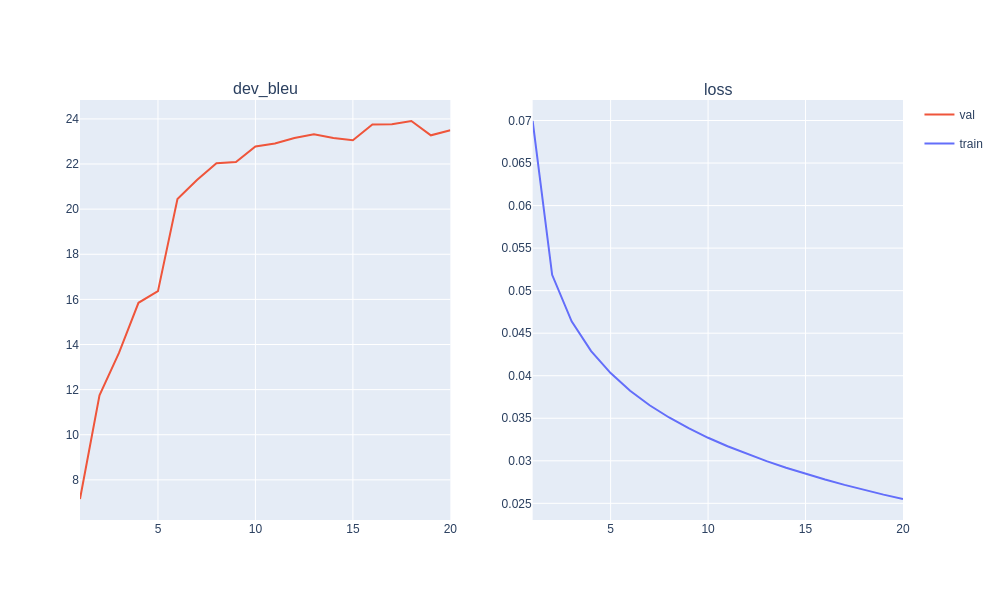

In [256]:
display(plotly_static(att_plotter.draw_no_widget()))

<a id="3_dest" href="#3_src">[back]</a> dot attention

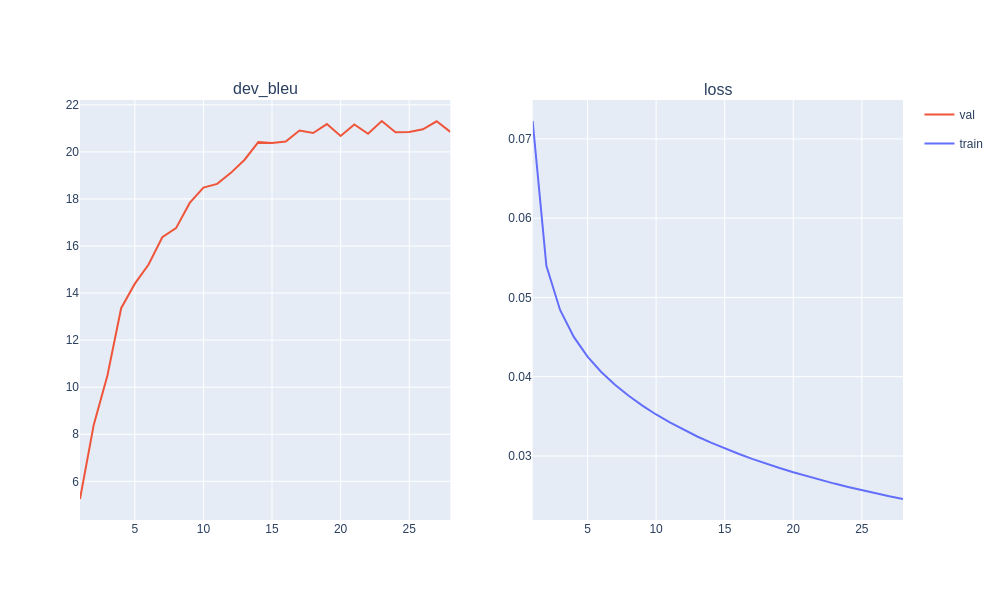

In [236]:
display(plotly_static(dot_plotter.draw_no_widget()))

<a id="4_dest" href="#4_src">[back]</a> dot attention cosine with warmup scheduler

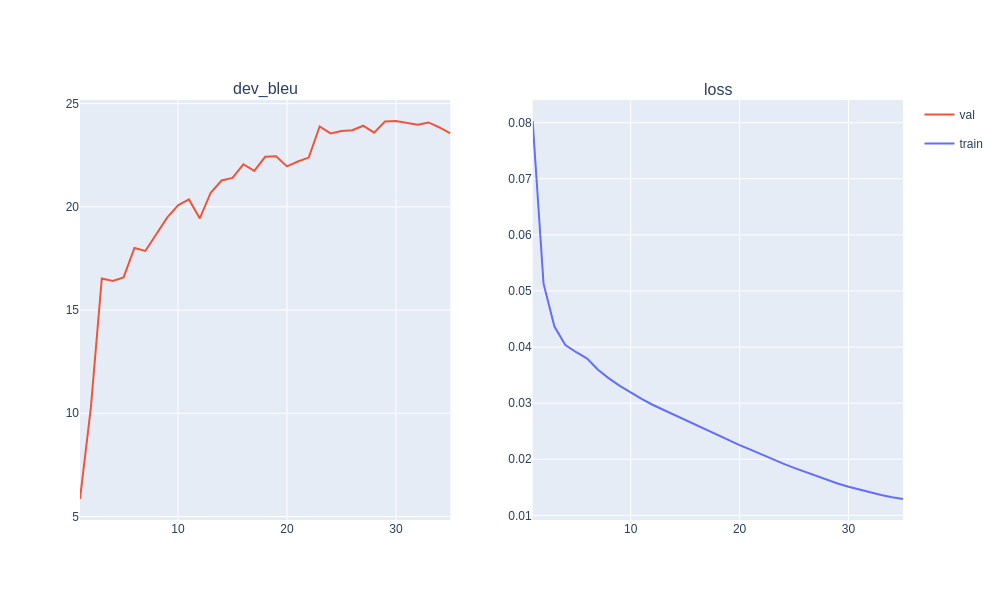

In [251]:
display(plotly_static(dot_warmup_plotter.draw_no_widget()))

<a id="5_dest" href="#5_src">[back]</a> multihead attention, no attention dropout

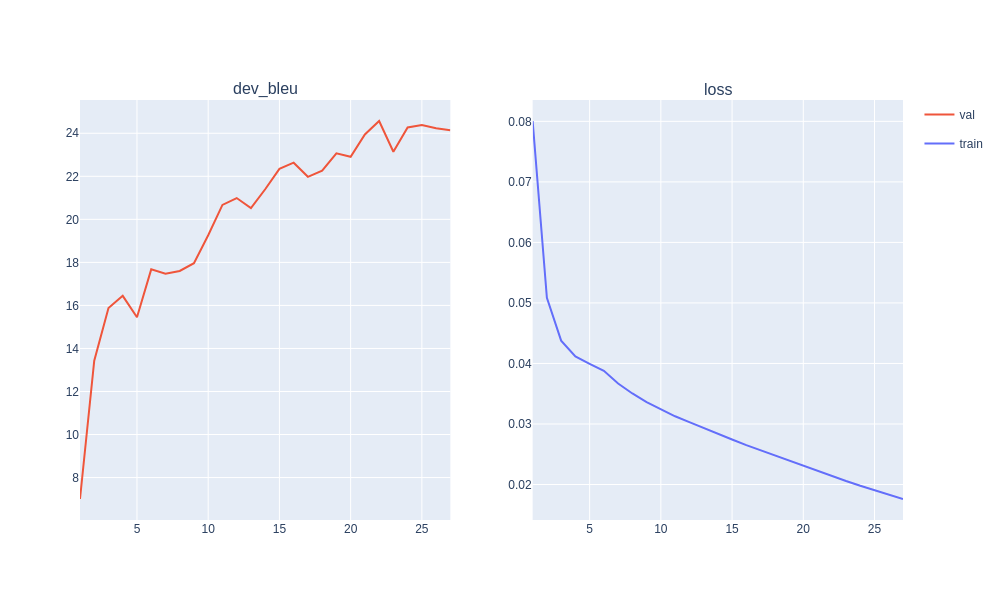

In [247]:
display(plotly_static(multih_plotter.draw_no_widget()))

<a id="6_dest" href="#6_src">[back]</a> multihead attention, attention dropout = 0.3

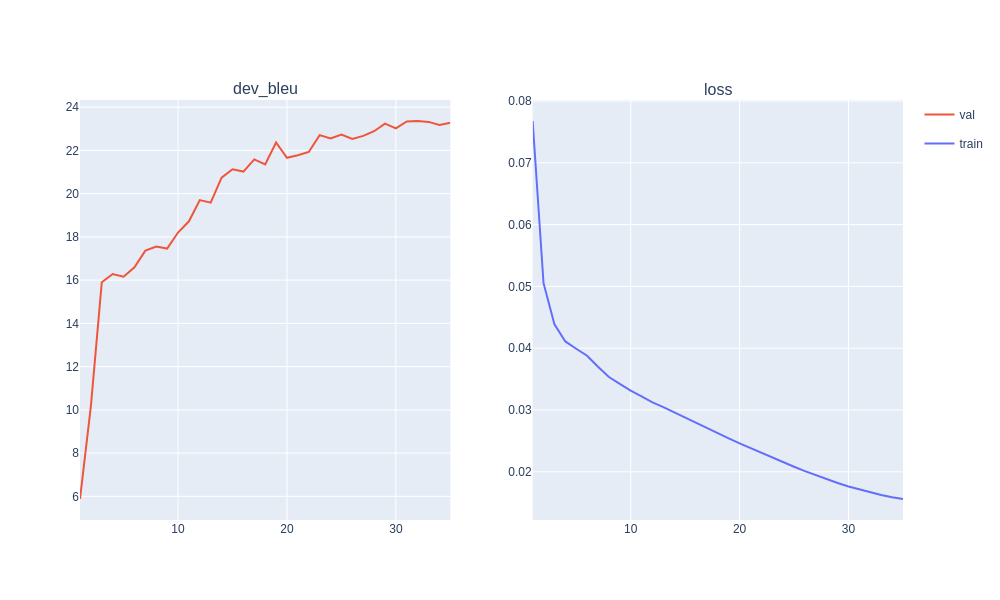

In [260]:
display(plotly_static(multih_drop_plotter.draw_no_widget()))

## <a id="toc_06_dest" href="#toc_06_src">[TOC]</a> external code

In [ ]:
# %load train
from collections import defaultdict
from typing import Callable, Any
from warnings import warn

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

try:
    from .magic import reprint
except ImportError:
    try:
        from magic import reprint
    except ImportError:
        warn("Couldn't load magic!")
        reprint = lambda t: t

__all__ = ["loopa", "ACC_METRIC", "EarlyStopper"]

ListOfMetrics = list[
    str |
    tuple[
        str,
        Callable[[torch.Tensor, torch.Tensor], Any], # metric calculation
        Callable[[list[Any]], float],                # metric aggregation
    ]
]

def to(X, device):
    if isinstance(X, dict):
        for key, val in X.items():
            X[key] = val.to(device)
        return X
    if isinstance(X, torch.Tensor):
        return X.to(device)
    raise RuntimeError(f"Incorrect type {type(X)}")

@reprint
def _loopa(*, model: nn.Module, dataloader: DataLoader, device: str,
           loss_fn, optim, metrics: ListOfMetrics,
           is_train: bool = True, accum_grad: int = 1,
           scheduler: torch.optim.lr_scheduler.LRScheduler | None = None):
    
    metric_lists = defaultdict(list)
    _metrics = []
    for metric in metrics:
        if isinstance(metric, str):
            if metric not in METRICS:
                raise RuntimeError(f"couldn't find metric: {metric}")
            _metrics.append((metric, *METRICS[metric]))
        else:
            _metrics.append(metric)
    metrics = _metrics
    do_loss = is_train or "loss" in next(zip(*metrics))
    
    if is_train: optim.zero_grad() if is_train else None
        
    for i, (X, y) in enumerate(tqdm(dataloader, desc="train phase" if is_train else "val phase")):
        X, y = to(X, device), to(y, device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y) / accum_grad if do_loss else None
        
        if is_train:
            loss.backward()
            if not (i + 1) % accum_grad:
                optim.step()
                optim.zero_grad()
            
        with torch.no_grad():
            for metric, fn, _ in metrics:
                if metric == "loss":
                    metric_lists["loss"].append(loss.item() * accum_grad)
                else:
                    metric_lists[metric].append(fn(y_pred, y))
    if scheduler is not None and is_train:
        scheduler.step()
    if is_train and (i + 1) % accum_grad:
        # optim.step()
        optim.zero_grad()
    
    metric_results = {}
    for key, _, agg in metrics:
        metric_results[key] = agg(metric_lists[key])
    
    return metric_results

@reprint
def loopa(model: nn.Module, dataloader: DataLoader, *, device: str,
           loss_fn=None, optim=None, metrics: ListOfMetrics,
           is_train: bool = True, accum_grad: int = 1,
           scheduler: torch.optim.lr_scheduler.LRScheduler | None = None):
    if is_train:
        model.train()
        return _loopa(model=model, dataloader=dataloader, device=device,
                      loss_fn=loss_fn, optim=optim, metrics=metrics, accum_grad=accum_grad,
                      is_train=is_train, scheduler=scheduler)
    
    with torch.no_grad():
        model.eval()
        ret = _loopa(model=model, dataloader=dataloader, device=device,
                     loss_fn=loss_fn, optim=optim, metrics=metrics, accum_grad=accum_grad,
                     is_train=is_train, scheduler=scheduler)
        model.train()
        return ret
    
def mean_metric(sum_of_metrics_func: Callable[[torch.Tensor, torch.Tensor], float | torch.Tensor]):
    # ! if return is torch.Tensor, it has to be a scalar
    collector = lambda y_pred, y_true: (sum_of_metrics_func(y_pred, y_true), len(y_true))
    def aggregator(results):
        correct, total = map(sum, zip(*results))
        ret = correct / total
        return ret.item() if isinstance(ret, torch.Tensor) else ret
    return collector, aggregator

METRICS = {
    "loss": [None, np.mean],
    "acc": mean_metric(lambda y_pred, y_true: (y_pred.argmax(-1) == y_true).sum()),
}


In [ ]:
# %load checkpoint
import os
from dataclasses import dataclass
from warnings import warn

import numpy as np
import torch
import torch.nn as nn

try:
    from plotter import History
except ImportError:
    try:
        from .plotter import History
    except ImportError:
        raise ImportError("download `plotter.py`")

@dataclass
class State:
    model: nn.Module
    optimizer: torch.optim.Optimizer
    history: "History"
    path: str
    scheduler: torch.optim.lr_scheduler.LRScheduler | None = None
    
    def __post_init__(self):
        if os.path.exists(self.path):
            warn(f"Saver: {self.path} already exists!")
    
    def save(self):
        state_dict = dict(model=self.model.state_dict(),
                          optimizer=self.optimizer.state_dict(),
                          history=self.history.state_dict())
        if self.scheduler is not None:
            state_dict["scheduler"] = self.scheduler.state_dict()
        torch.save(state_dict, self.path)
        self.save_history()
    
    def load_inplace(self):
        chkp = torch.load(self.path, "cpu")
        self.model.load_state_dict(chkp["model"])
        self.optimizer.load_state_dict(chkp["optimizer"])
        self.history.load_state_dict(chkp["history"])
        if self.scheduler is not None:
            self.scheduler.load_state_dict(chkp["scheduler"])
        
    def save_history(self):
        # for learning curves, need full history not just until the best
        torch.save(self.history.state_dict(),
                   f"{self.path}.history")
        
    def load_history(self):
        his = History()
        his.load_state_dict(torch.load(f"{self.path}.history"))
        return his
    
    def as_tuple(self):
        return self.model, self.optimizer, self.history, self.scheduler
    
@dataclass
class EarlyStopper:
    state: State
    loss: str = "loss"
    patience: int | None = 3
    min_delta: float = 0
    
    _last_history_len: int = None
    
    def __post_init__(self):
        self.best_epoch: int = -1 if not len(self.state.history) else self.get_losses().argmin() + 1
        self.best_loss = np.inf if not len(self.state.history) else self.get_losses().min()
        
    def __str__(self):
        if self.loss.startswith("-"):
            metric = self.loss[1:]
            sign = -1
        else:
            metric = self.loss
            sign = 1
        return f"based on metric: {metric}, best epoch: {self.best_epoch}, best value: {sign * self.best_loss}"
    
    def get_losses(self):
        if self.loss.startswith("-"):
            metric = self.loss[1:]
            sign = -1
        else:
            metric = self.loss
            sign = 1
        return np.array([sign * res[metric]
                         for res in self.state.history.val
                         if metric in res])
    
    def hist_changed(self):
        return len(self.state.history) != self._last_history_len
    
    def __call__(self):
        """
        saves model on improvement
        returns True if training should stop else False
        """
        if not self.hist_changed(): return False
        
        self._last_history_len = len(self.state.history)
        losses = self.get_losses()
        
        if not len(losses):
            return False
        
        self._last_history_len = len(losses)
        
        if losses[-1] <= self.best_loss:
            self.best_loss = losses[-1]
            self.best_epoch = len(self.state.history)
            self.state.save()
            return False
        return len(losses) > self.patience and np.all(losses[-self.patience:] > self.best_loss + self.min_delta)


In [ ]:
# %load magic
import ast
import inspect
from _ast import (
    Call,
    Expr,
    FunctionDef,
    Module,
    Name,
)
from collections import defaultdict
from itertools import count
from types import FunctionType, CodeType
from typing import Any, Iterable

from IPython import get_ipython
from IPython.core.magic import register_cell_magic
from IPython.display import clear_output, display
from ipywidgets import Output
from tqdm.auto import tqdm


class MyOutput(Output):
    def __init__(self):
        super().__init__()
        display(self)
        
class ReusableTqdm:
    def __init__(self):
        self.tqdm = tqdm([None])
    
    def __call__(self, iterable: Iterable, **kwargs):
        try:
            self.tqdm.total = len(iterable)
        except TypeError:
            self.tqdm.total = None
        
        for key, val in kwargs.items():
            setattr(self.tqdm, key, val)
        
        self.tqdm.reset()
        if self.tqdm.total is not None:
            self.tqdm.container.children[1].max = self.tqdm.total
        
        for entry in iterable:
            yield entry
            self.tqdm.update()
            self.tqdm.refresh()
    
_OUTPUTS = defaultdict(MyOutput)
_TQDMS = defaultdict(ReusableTqdm)

def _reprint(*args, _caller_id, **kwargs):
    if None in _caller_id:
        # function was called without magic applied to all levels
        return print(*args, **kwargs)    
    
    output = _OUTPUTS[_caller_id]

    with output:
        output.clear_output()
        print(*args, **kwargs)

def _retqdm(*args, _caller_id, **kwargs):
    if None in _caller_id:
        # function was called without magic applied to all levels
        yield from tqdm(*args, **kwargs)
        return
    
    tqdm_creator = _TQDMS[_caller_id]
    
    yield from tqdm_creator(*args, **kwargs)
    

###########################################################

reprintable_funcs = {"print", "tqdm"}

def get_expr_ast(line: str):
    res = ast.parse(line).body[0]
    return res.value if isinstance(res, Expr) else res

def copy_data(dest, src):
    ast.copy_location(dest, src)
    ast.fix_missing_locations(dest)

class PrintTransformer(ast.NodeTransformer):
    def __init__(self) -> None:
        self.count = count()
        super().__init__()

    def visit_Call(self, node: Call) -> Call:
        func = node.func
        if isinstance(func, Name) and func.id in reprintable_funcs:
            if func.id in ["print", "tqdm"]:
                node.func = get_expr_ast(f"reprint.{func.id}")
                copy_data(node.func, node)
            node.keywords.append(ast.keyword(
                arg="_caller_id",
                value=get_expr_ast(f"_caller_id + ({next(self.count)}, )")
            ))
            
            copy_data(node.keywords[-1], node)

        return super().generic_visit(node)
    
    def visit_Module(self, node: Module) -> Module:
        # crutch for module-level func callers
        node.body.insert(0, get_expr_ast(f'_caller_id = ()'))
        
        for statement in node.body:
            if isinstance(statement, FunctionDef):
                reprintable_funcs.add(statement.name)
                statement.args.kwonlyargs.append(ast.arg(arg="_caller_id"))
                statement.args.kw_defaults.append(get_expr_ast("(None,)"))
                
                copy_data(statement.args.kwonlyargs[-1], statement.args)
                copy_data(statement.args.kw_defaults[-1], statement.args)
                
        return super().generic_visit(node)

    def __eq__(self, other):
        return self is other


ipy = get_ipython()


@register_cell_magic
def reprint(f, cell = None):
    tr = PrintTransformer()
    if cell is not None:
        # magic call
        _OUTPUTS.clear()
        _TQDMS.clear()
        clear_output()
        ipy.ast_transformers.append(tr)
        ipy.run_cell(cell)
        if tr in ipy.ast_transformers:
            ipy.ast_transformers.remove(tr)
    else:
        # decorator call
        # https://devmessias.github.io/post/python_ast_metaprogramming_with_introspection_and_decorators/#creating-a-new-function-at-runtime
        source = inspect.getsource(f)
        source = "\n".join(line
                           for line in source.split("\n")
                           if not line.startswith("@reprint"))
        tree = ast.parse(source)
        tree = tr.visit(tree)
        code_obj = compile(tree, f.__code__.co_filename, 'exec')
        function_code = [c for c in code_obj.co_consts if isinstance(c, CodeType)][0]
        transformed_func = FunctionType(function_code, f.__globals__, argdefs=f.__defaults__)
        
        kw_default = (f.__kwdefaults__ or {}) | {"_caller_id" : (None,)}
        return lambda *args, **kwargs: transformed_func(*args, **(kw_default | kwargs))

reprint.print = _reprint
reprint.tqdm = _retqdm
    
def display_no_widgets(plotter, outs=None):
    clear_output()
    display(plotter.draw_no_widget())
    if outs is None:
        outs = _OUTPUTS.values()
    print("\n".join(output.outputs[0]["text"] for output in outs if output.outputs))

def get_outputs():
    return _OUTPUTS.values()

class SoftCtrlCTransformer(ast.NodeTransformer):
    def visit_Module(self, node: Module) -> Module:
        try_ = ast.parse("""
try:
    pass
except KeyboardInterrupt:
    print("interrupted by keyboard")
""")
        try_.body[0].body = node.body

        return super().generic_visit(try_)

    def __eq__(self, other):
        return self is other

@register_cell_magic
def soft_ctrl_c(_, cell):
    tr = SoftCtrlCTransformer()
    ipy.ast_transformers.append(tr)
    ipy.run_cell(cell)
    if tr in ipy.ast_transformers:
        ipy.ast_transformers.remove(tr)


In [ ]:
# %load plotter
import warnings
from dataclasses import dataclass, field
from math import ceil
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Image
from plotly.subplots import make_subplots
from tqdm.auto import tqdm


Report = dict[str, float]
@dataclass
class History:
    train: list[Report] = field(default_factory=list)
    val: list[Report] = field(default_factory=list)
    drop_query: str = 'phase != phase' # query to return none
    
    def push_epoch(self, *reports: tuple[Report, Report] | tuple[Report]) -> None:
        if len(reports) == 1:
            val_report, = reports
            train_report = {}
        else:
            train_report, val_report = reports
        self.train.append(train_report)
        self.val.append(val_report)
    
    def as_dfs(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        # return metrics as 2 DataFrames with additional epoch and phase (train / val) columns
        # for plotting
        
        df = pd.concat(map(pd.DataFrame, [self.train, self.val]),
                       keys=["train", "val"])\
                .reset_index(names=["phase", "epoch"])
        df.epoch += 1
        
        return df.query(f"not ({self.drop_query})"), df.query(self.drop_query)
    
    def as_df(self) -> pd.DataFrame:
        return self.as_dfs()[0]
    
    def __len__(self) -> int:
        return len(self.train)
    
    def range(self, max_epochs, stopper = None, do_tqdm = False):
        loop = range(max(max_epochs, 0))
        skip = len(self)
        if do_tqdm:
            loop = tqdm(loop, desc="epoch")
            
        for i in loop:
            if i < skip:
                continue
            if stopper and stopper():
                break
            yield i
            
            if stopper and stopper.hist_changed():
                stopper.state.save_history()
                
        if stopper and stopper.hist_changed():
                stopper.state.save_history()
    
    def state_dict(self):
        return {field : getattr(self, field) for field in ["train", "val", "drop_query"]}
    
    def load_state_dict(self, dict_):
        return {field : setattr(self, field, dict_[field]) for field in ["train", "val", "drop_query"]}

@dataclass
class Plotter:
    metrics: list[str] = field(default_factory=list)
    titles: list[str] = field(default_factory=list)
    height: int = 600
    width: int = 1000
    plot_cols: int = 3
    path: Path | str | None = None
    bound_history: History | None = None
    # custom_range: dict[str, tuple[int, int]] = field(default_factory=dict)
    
    def __post_init__(self):
        if self.path is not None:
            self.path = Path(self.path)
            if self.path.exists():
                warnings.warn("File already exists!")
            
        self._inited = False
        if not self.titles:
            self.titles = self.metrics
        
        self.fig: plotly.graph_objs._figure.Figure
        self.traces = {}
        self.names = set()
        
    def init_canvas(self):
        plot_cols = min(self.plot_cols, len(self.metrics))
        plot_rows = max(1, ceil(len(self.metrics) / plot_cols))
        self.fig = go.FigureWidget(make_subplots(rows=plot_rows, cols=plot_cols, subplot_titles=self.titles))
        self.fig.update_layout(height=self.height, width=self.width, showlegend=True)
        display(self.fig)
    
    def display(self):
        display(self.fig)
    
    def plot(self, history: History | None = None):
        if history is None:
            history = self.bound_history
            assert history is not None
        
        df_kept, df_dropped = history.as_dfs()
        if not self._inited:
            if not self.metrics:
                self.metrics = self.titles = list(set(df_dropped.columns) - {"phase", "epoch"})
            self.init_canvas()
            self._inited = True
        
        for handle, df in ("kept", df_kept), ("dropped", df_dropped):
            for i, metric in enumerate(self.metrics):
                for trace in px.scatter(df.dropna(subset=metric),
                                        x="epoch", y=metric,
                                        color="phase", color_discrete_map={"train" : "#636efa",
                                                                           "val" : "#EF553B"})["data"]:
                    if (handle, metric, trace.name) in self.traces:
                        _trace = self.traces[(handle, metric, trace.name)]
                        # avoid unneeded assignments, for they cause lags
                        if _trace.y.shape != trace.y.shape:
                            _trace.x, _trace.y = trace.x, trace.y
                        trace = _trace
                    else:
                        self.fig.append_trace(
                            trace,
                            row=i // self.plot_cols + 1, col=i % self.plot_cols + 1
                        )
                        self.traces[(handle, metric, trace.name)] = trace = self.fig.data[-1]
                        # remove duplicate legends
                        if trace.name in self.names:
                            trace.update(showlegend=False)
                        else:
                            self.names.add(trace.name)
                            
                    if trace.x.size > 1 and trace.mode != "lines" and handle != "dropped":
                        trace.mode = "lines"
                        
                    if handle == "dropped" and ("kept", metric, trace.name) in self.traces:
                        kept = self.traces[("kept", metric, trace.name)]
                        y = np.full_like(trace.y, kept.y[0])
                        
                        if not all(trace.y == y) or trace.marker["symbol"] != "star":
                            trace.customdata = trace.y[:, None]
                            trace.y = y
                            trace.hovertemplate = trace.hovertemplate.replace(
                                "%{y}",
                                "%{customdata[0]:.2f}" + f"({history.drop_query})"
                            )
                            trace.mode = "markers"
                            trace.marker["symbol"] = "star"
                            trace.marker["size"] = 10
                            trace.marker["color"] = kept.marker["color"]
                    
        if self.path is not None:
            self.fig.write_image(self.path)
            self.fig.write_html(str(self.path) + ".html")
            
    def draw_no_widget(self):
        return plotly.io.from_json(self.fig.to_json())

def plotly_static(fig: plotly.graph_objs._figure.Figure, format: str = "png") -> Image:
    return Image(fig.to_image(format=format))


In [ ]:
# %load torch_utils
from functools import wraps, partial
from typing import TypeVar, Iterable, Hashable

import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

class Apply(nn.Module):
    def __init__(self, func, *func_args, **func_kwargs):
        super().__init__()
        self.func = func
        self.func_args = func_args
        self.func_kwargs = func_kwargs
    
    def forward(self, X):
        return self.func(X, *self.func_args, **self.func_kwargs)
    
Arr = TypeVar("Arr", torch.Tensor, np.array)

def normalize(x: Arr, dim: int = -1, ord: int | float | str= 2, eps: float = 1e-6) -> Arr:
    if isinstance(x, np.ndarray):
        norm = np.linalg.norm(x, ord=ord, axis=dim, keepdims=True)
    else:
        norm = x.norm(dim=dim, p=ord, keepdim=True)
    return x / (norm + eps)

def train_val_test_split(*arrays, val_size: float, test_size: float = 0, **kwargs):
    rets_train_val = train_test_split(*arrays, test_size=test_size + val_size, **kwargs)
    
    val_size_cond = val_size / (test_size + val_size)
    rets_val_test = train_test_split(*rets_train_val[1::2], train_size=val_size_cond, **kwargs)
    
    train, val, test = rets_train_val[::2], rets_val_test[::2], rets_val_test[1::2]
    
    return sum(zip(train, val, test), start=())

def device_default(f, globs=None):
    if isinstance(f, dict):
        return partial(device_default, globs=f)
    @wraps(f)
    def inner(*args, device=None, **kwargs):
        if device is None:
            device = (globs or f.__globals__)["device"]
        return f(*args, **kwargs, device=device)
    return inner

def map_idx(values: Iterable[Hashable]) -> dict[Hashable, int]:
    return {value : idx for idx, value in enumerate(values)}

